# import required package

In [1]:
import pandas as pd
import numpy as np
import re    
import nltk
import string
import spacy
from sklearn.preprocessing import normalize
from scipy.spatial import distance
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

# Read data

In [2]:
#read conbined info from each bar , f:first csv file, end-1:last csv file
def read_reviews(f,end):
    rere=[]
    for i in range(f,end):
        name=i.__str__()
        data=pd.read_csv("/Users/hankchen/Desktop/semester2/660/final_project/wine bar/"+name+".csv",header=0)
        gg=data["Description"].copy()
        gg=pre_remove(gg)
        for j in gg:
            rere.append(j)
    return rere

def read_rating(f,end):
    rating=[]
    for i in range(f,end):
        name=i.__str__()
        data=pd.read_csv("/Users/hankchen/Desktop/semester2/660/final_project/wine bar/"+name+".csv",header=0)
        rr=data["Reting"].copy()
        for j in rr:
            rating.append(j)
    return rating

def read_label(f,end):
    label_senti=[]
    for i in range(f,end):
        name=i.__str__()
        data=pd.read_csv("/Users/hankchen/Desktop/semester2/660/final_project/wine bar/"+name+".csv",header=0)
        rr=data["label"].copy()
        for j in rr:
            label_senti.append(j)
    return label_senti

# Data Preprocessing
In this section, we tokenized the reviews from each wine bar, including turning the text to lower case and removing the emojis in the text.
Remove the punctuations and stopwords then lemmatization the words.

In [3]:
#tokenize and prepare for the reviews
def tokenize(reviews):
    
    bigrams=[]
    for i in range(len(reviews)):
        #turn the text to lower case
        reviews[i]=reviews[i].lower()

        #remove emoji in the text
        RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
        reviews[i] = RE_EMOJI.sub(r'', reviews[i])

        #tokenize the text
        reviews[i]= nltk.word_tokenize(reviews[i])

        #remove the punctuations
        reviews[i]=[token.strip(string.punctuation) for token in reviews[i]]

        #remove the stopword
        reviews[i]=[token for token in reviews[i] if token not in stop_words]
        
        #remove the empty tokens
        reviews[i]=[token.strip() for token in reviews[i] if token.strip()!='']

        ##Lemmatization
        for j in range(len(reviews[i])):        
            reviews[i][j]=lemmatizer.lemmatize(reviews[i][j])
            
        #form bigrams
        bigrams.append(list(nltk.bigrams(reviews[i])))
        
    return reviews

def pre_remove(reviews):
    for i in range(len(reviews)):
        #turn the text to lower case
        reviews[i]=reviews[i].lower()

        #remove emoji in the text
        RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
        reviews[i] = RE_EMOJI.sub(r'', reviews[i])
        
    return reviews

In [4]:
#Create tf-idf matrix
def to_matrix(x):
    docs_tokens={idx:nltk.FreqDist(doc) for idx,doc in enumerate(x)}
        #convert dictionary to matrix
    dtm=pd.DataFrame.from_dict(docs_tokens,orient="index" )
    dtm=dtm.fillna(0)
        # get term frequency matrix
    tf=dtm.values
    doc_len=tf.sum(axis=1) 
    tf=np.divide(tf, doc_len[:,None])
        # get Inverse Document Frequency
    df=np.where(tf>0,1,0)
    idf=np.log(np.divide(len(x)+1,  np.sum(df, axis=0)+1))+1
        # get tf-idf
    tf_idf=normalize(tf*idf)
    return tf_idf


# Naive sentiment analysis 
We performed simple naive sentiment analysis for each store to get the sentiment of the reviews
The positive and negative dictionary are provided by class materials.
We using first five wine bar as our training model.


In [5]:
#Naive sentiment analysis 
with open("/Users/hankchen/Desktop/semester2/660/NLP/positive-words.txt",'r') as f:
    positive_words=[line.strip() for line in f]
with open("/Users/hankchen/Desktop/semester2/660/NLP/negative-words.txt",'r') as f:
    negative_words=[line.strip() for line in f]
negations=['not', 'too', 'n\'t', 'no', 'cannot', 'neither','nor']
positive_count=[]
negative_count=[]

rere=read_reviews(1,5)
reviews=tokenize(rere)
for i in range(len(reviews)):
    
    #count the positive words
    positive_tokens=[]
    for idx, token in enumerate(reviews[i]):
        if token in positive_words:
            if idx>0:
                if reviews[i][idx-1] not in negations:
                    positive_tokens.append(token)
            else:
                positive_tokens.append(token)
    positive_count.append(len(positive_tokens))
    
    #count the negative words
    negative_tokens=[]
    for idx, token in enumerate(reviews[i]):
        if token in negative_words:
            if idx>0:
                if reviews[i][idx-1] not in negations:
                    negative_tokens.append(token)
            else:
                negative_tokens.append(token)
    negative_count.append(len(negative_tokens)) 
#compare the count number of positive with negative word
sentiment=[]
for i in range(len(negative_count)):
    if negative_count[i] > positive_count[i]:
        sentiment.append("0")   #negative
    elif negative_count[i] < positive_count[i]:
        sentiment.append("1")   #positive
    else:
        sentiment.append("0")    #neutral
general=dict((a,sentiment.count(a)) for a in sentiment)
general
#len(negative_count)


{'1': 1233, '0': 197}

## Accuracy - assign the neutral sentiment to negative labels

In [6]:
#compare the count number of positive with negative word
#assign the neutral sentiment to negative labels
sentiment=[]
for i in range(len(negative_count)):
    if negative_count[i] > positive_count[i]:
        sentiment.append(0)   #negative
    elif negative_count[i] < positive_count[i]:
        sentiment.append(1)   #positive
    else:
        sentiment.append(0)    #neutral
#calculate the accuracy of naive sentiment analysis 
label_senti=read_label(1,5)
auc1=accuracy_score(list(map(int, sentiment)),label_senti)
print(auc1)
print(classification_report(label_senti,sentiment, target_names=["0","1"]))
pd.crosstab(pd.Series(label_senti),pd.Series(sentiment))

0.8643356643356643
              precision    recall  f1-score   support

           0       0.30      0.51      0.38       117
           1       0.95      0.90      0.92      1313

   micro avg       0.86      0.86      0.86      1430
   macro avg       0.63      0.70      0.65      1430
weighted avg       0.90      0.86      0.88      1430



col_0,0,1
row_0,,
0,60,57
1,137,1176


In [7]:
#compare th result of naive sentiment analysis with rating scoere
sentiment=[]
for i in range(len(negative_count)):
    if negative_count[i] > positive_count[i]:
        sentiment.append("negative")   
    elif negative_count[i] < positive_count[i]:
        sentiment.append("positive")   
    else:
        sentiment.append("neutral")    
pd.crosstab(pd.Series(sentiment),pd.Series(label_senti))

col_0,0,1
row_0,,
negative,23,27
neutral,37,110
positive,57,1176


## Accuracy - assign the neutral sentiment to positive labels

In [8]:
#compare the count number of positive with negative word
#assign the neutral sentiment to positive labels
sentiment=[]
for i in range(len(negative_count)):
    if negative_count[i] > positive_count[i]:
        sentiment.append(0)   #negative
    elif negative_count[i] < positive_count[i]:
        sentiment.append(1)   #positive
    else:
        sentiment.append(1)    #neutral
#calculate the accuracy of naive sentiment analysis 
label_senti=read_label(1,5)
auc1=accuracy_score(list(map(int, sentiment)),label_senti)
print(auc1)
print(classification_report(label_senti,sentiment, target_names=["0","1"]))
pd.crosstab(pd.Series(label_senti),pd.Series(sentiment))

0.9153846153846154
              precision    recall  f1-score   support

           0       0.46      0.20      0.28       117
           1       0.93      0.98      0.96      1313

   micro avg       0.92      0.92      0.92      1430
   macro avg       0.70      0.59      0.62      1430
weighted avg       0.89      0.92      0.90      1430



col_0,0,1
row_0,,
0,23,94
1,27,1286


## Accuracy - Using rating as Target

In [9]:
#Accoding to the rating score, created a feature for sentiment analysis
level_rating=[]
rrating=read_rating(1,5)
for i in rrating:
    if i>4:
        level_rating.append(1)#"positive"
    elif i==4:
        level_rating.append(1)#"neutral"
    else:
        level_rating.append(0)#"negative"

auc1=accuracy_score(list(map(int, level_rating)),label_senti)
print(auc1)
print(classification_report(level_rating,label_senti, target_names=["0","1"]))
pd.crosstab(pd.Series(level_rating),pd.Series(label_senti))

0.9664335664335665
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       145
           1       0.97      0.99      0.98      1285

   micro avg       0.97      0.97      0.97      1430
   macro avg       0.94      0.87      0.90      1430
weighted avg       0.97      0.97      0.96      1430



col_0,0,1
row_0,,
0,107,38
1,10,1275


## Support Vector Machine

0.8433196747343683
col_0   0    1
row_0         
0      14    6
1      26  240
              precision    recall  f1-score   support

           0       0.35      0.70      0.47        20
           1       0.98      0.90      0.94       266

   micro avg       0.89      0.89      0.89       286
   macro avg       0.66      0.80      0.70       286
weighted avg       0.93      0.89      0.90       286

0.8881118881118881
0.9028195488721803


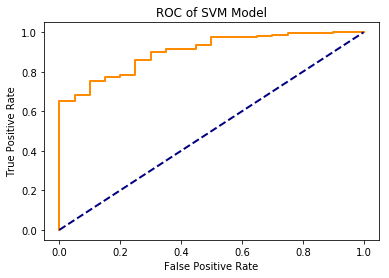

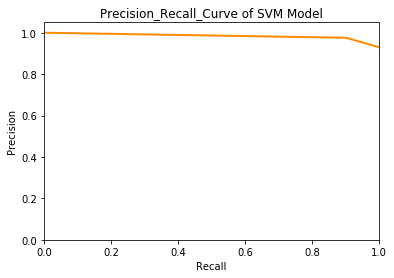

In [10]:
#perform sentiment analysis classification

rere=read_reviews(1,5) #data to build trainning model
label_senti=read_label(1,5)
#rere=tokenize(rere)
#mama=to_matrix(rere)
tfidf_vect = TfidfVectorizer(stop_words='english',min_df=5) 
mama= tfidf_vect.fit_transform(rere)    
   
class_weights = {1:0.5,0:30}

clf2 = svm.SVC(kernel='linear', class_weight=class_weights)
metrics = ['roc_auc']
cv2 = cross_validate(clf2, mama, label_senti,scoring=metrics, cv=5,return_train_score=True)
print(np.mean(cv2['test_roc_auc']))


X_train, X_test, y_train, y_test = train_test_split(mama,label_senti, test_size=0.2, random_state=0)

svc = svm.SVC(kernel='linear',probability=True, class_weight=class_weights)
model = svc.fit(X_train, y_train)
predicted2=model.predict(X_test)

print(pd.crosstab(pd.Series(y_test), pd.Series(predicted2)))
print(classification_report(y_test, predicted2, target_names=['0','1']))
print(accuracy_score(y_test,predicted2))

#calculate AUC
predict_p=model.predict_proba(X_test)
y_pred = predict_p[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred,pos_label=1)
print(auc(fpr, tpr))

#plot ROC curve
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC of SVM Model');
plt.show();

#plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test,predicted2, pos_label=1)
plt.figure();
plt.plot(recall, precision, color='darkorange', lw=2);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision_Recall_Curve of SVM Model');
plt.show();



## Test data - Wagonhouse Winery

In [11]:
#to predict the sentiment 
pp=read_reviews(19,20)   
new_tfidf = tfidf_vect.transform(pp) 
svc2 = svm.SVC(kernel='linear',probability=True, class_weight=class_weights)
model = svc2.fit(mama, label_senti)
predicted3=model.predict(new_tfidf)

# Assign topic
We assign the reviews into four topics and calculate their accuracy

In [12]:
#multi-label classification on the topic
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB

data=pd.read_csv("/Users/hankchen/Desktop/semester2/660/final_project/660 final/Trainning_mutilabeled.csv",header=0)
dtd=pre_remove(data["Description"].copy())
tfidf_vect = TfidfVectorizer(stop_words='english',min_df=5) 
mama2= tfidf_vect.fit_transform(dtd)
label_senti2=data[["Food","Service","Atmosphere","Price"]].copy()
classifier = BinaryRelevance(svm.LinearSVC())

X_train, X_test, y_train, y_test = train_test_split(mama2,label_senti2, test_size=0.3, random_state=0)
# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)
# convert from sparse matrix to dataframe
ppp=pd.DataFrame(predictions.toarray(),columns=["Foodp","Servicep","Atmospherep","Pricep"])

print("total-AUC:",accuracy_score(y_test,predictions))

print(classification_report(y_test, predictions,target_names=['Food','Service','Atmosphere','Price']))


print(pd.crosstab(y_test["Food"],ppp["Foodp"]))
print("Food-AUC:",accuracy_score(y_test["Food"],ppp["Foodp"]))

print(pd.crosstab(y_test["Service"],ppp["Servicep"]))
print("Service-AUC:",accuracy_score(y_test["Service"],ppp["Servicep"]))

print(pd.crosstab(y_test["Atmosphere"],ppp["Atmospherep"]))
print("Atmosphere-AUC:",accuracy_score(y_test["Atmosphere"],ppp["Atmospherep"]))

print(pd.crosstab(y_test["Price"],ppp["Pricep"]))
print("Price-AUC:",accuracy_score(y_test["Price"],ppp["Pricep"]))

total-AUC: 0.6462264150943396
              precision    recall  f1-score   support

        Food       0.89      0.95      0.92       149
     Service       0.87      0.79      0.83        77
  Atmosphere       0.72      0.65      0.68        60
       Price       0.58      0.58      0.58        26

   micro avg       0.83      0.82      0.83       312
   macro avg       0.77      0.74      0.75       312
weighted avg       0.83      0.82      0.82       312
 samples avg       0.69      0.68      0.67       312

Foodp   0   1
Food         
0       1   5
1      10  42
Food-AUC: 0.8820754716981132
Servicep   0   1
Service         
0         16   7
1         18  17
Service-AUC: 0.8820754716981132
Atmospherep   0   1
Atmosphere         
0            31  17
1             6   4
Atmosphere-AUC: 0.8301886792452831


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


Pricep   0  1
Price        
0       48  9
1        1  0
Price-AUC: 0.8962264150943396


Average precision score, micro-averaged over all classes: 0.75


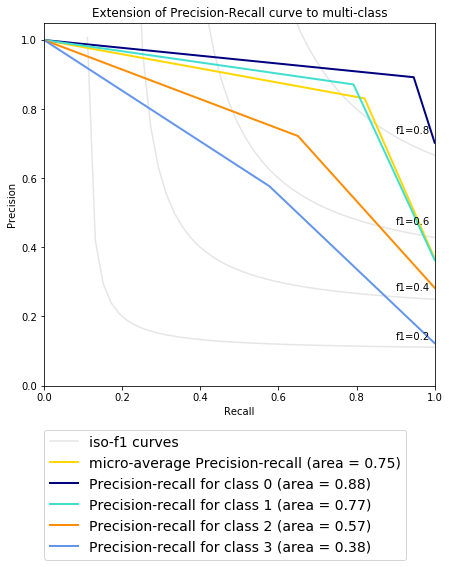

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
y_test=np.array(y_test)
ppp=np.array(ppp)
precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],ppp[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], ppp[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),ppp.ravel())
average_precision["micro"] = average_precision_score(y_test, ppp,average="micro")

print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))
#############################################################

from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(4), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.48), prop=dict(size=14))


plt.show()

## Test data - Wagonhouse Winery

In [14]:
#to predict the topic
dtd=pre_remove(data["Description"].copy())
tfidf_vect = TfidfVectorizer(stop_words='english',min_df=5) 
mama2= tfidf_vect.fit_transform(dtd)
label_senti2=data[["Food","Service","Atmosphere","Price"]].copy()
classifier = BinaryRelevance(svm.LinearSVC())
classifier.fit(mama2, label_senti2)

#pp=read_reviews(14,15)   
new_tfidf2 = tfidf_vect.transform(pp) 
predictions2 = classifier.predict(new_tfidf2)
predictions2=pd.DataFrame(predictions2.toarray(),columns=["Foodp","Servicep","Atmospherep","Pricep"])

In [15]:
#Result interpret
Food=pd.crosstab(predictions2["Foodp"],predicted3).iloc[1,:]
Service=pd.crosstab(predictions2["Servicep"],predicted3).iloc[1,:]
Atmosphere=pd.crosstab(predictions2["Atmospherep"],predicted3).iloc[1,:]
Price=pd.crosstab(predictions2["Pricep"],predicted3).iloc[1,:]
result=pd.DataFrame(dict(Food=Food, Service=Service,Atmosphere=Atmosphere,Price=Price))
print("total reviews:",len(pp))
print("Food:",result.iloc[0,0]/(result.iloc[0,0]+result.iloc[1,0]))
print("Service:",result.iloc[0,1]/(result.iloc[0,1]+result.iloc[1,1]))
print("Atmosphere:",result.iloc[0,2]/(result.iloc[0,2]+result.iloc[1,2]))
print("Price:",result.iloc[0,3]/(result.iloc[0,3]+result.iloc[1,3]))
result

total reviews: 321
Food: 0.20187793427230047
Service: 0.1509433962264151
Atmosphere: 0.22279792746113988
Price: 0.47368421052631576


,Food,Service,Atmosphere,Price
col_0,,,,
0,43,16,43,9
1,170,90,150,10


# Word Cloud - Black is negtive, White is positive

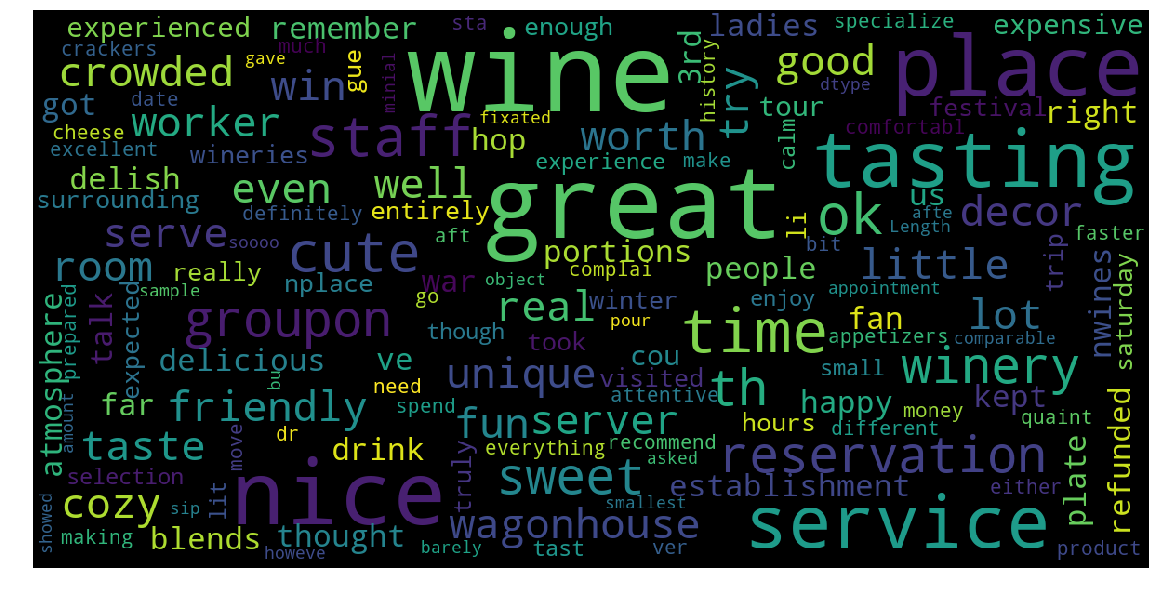

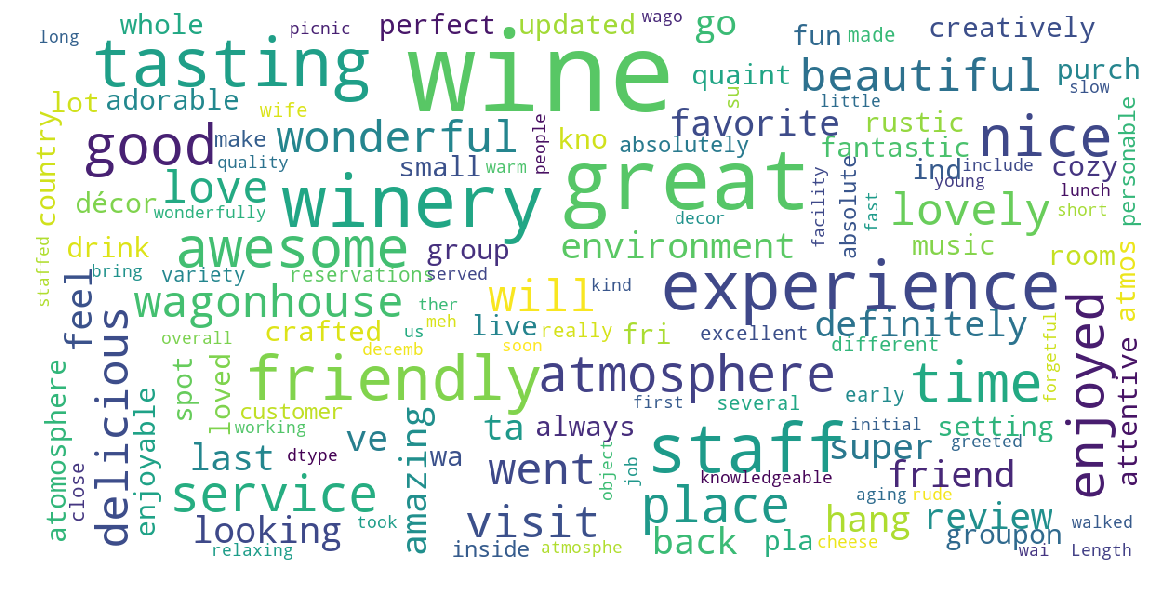

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
p3=list(predicted3)  #get the predicted sentiment
cloud=pd.Series(pp)  #get the reviews
wc0=cloud[[i for i in range(len(p3)) if p3[i] == 0]]  #get all the negative reviews
wc1=cloud[[i for i in range(len(p3)) if p3[i] == 1]]  #get all the  positive reviews
#calculate the word cloud for negative reviews
wordcloud = WordCloud(background_color = 'black',max_words = 200,max_font_size = 40, scale = 3,random_state = 42).generate(str(wc0))
fig = plt.figure(1, figsize = (20, 20))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()
#calculate the word cloud for positive reviews
wordcloud = WordCloud(background_color = 'white',max_words = 200,max_font_size = 40, scale = 3,random_state = 42).generate(str(wc1))
fig = plt.figure(1, figsize = (20, 20))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()